In [386]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random
import torchattacks

%matplotlib inline

# NOTE: This is a hack to get around "User-agent" limitations when downloading MNIST datasets
#       see, https://github.com/pytorch/vision/issues/3497 for more information
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)


pretrained_model = "lenet_mnist_model.pth"
use_cuda=True


######################################################################
# Model Under Attack
# ~~~~~~~~~~~~~~~~~~
# 
# As mentioned, the model under attack is the same MNIST model from
# `pytorch/examples/mnist <https://github.com/pytorch/examples/tree/master/mnist>`__.
# You may train and save your own MNIST model or you can download and use
# the provided model. The *Net* definition and test dataloader here have
# been copied from the MNIST example. The purpose of this section is to
# define the model and dataloader, then initialize the model and load the
# pretrained weights.
# 

# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x, softing = True):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        if softing == True:    
            return F.log_softmax(x, dim=1)
        else:
            return x

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()



CUDA Available:  True


In [ ]:
# Find the index of the element with the largest probability that is not the target
def largest_non_target(output, target):
    ind=-1
    biggest=float('-inf')
    for i in range(len(output[0])):
        if output[0][i]>biggest:
            if i!=target:
                ind=i
                biggest=output[0][i]
            
            
    ind = torch.reshape(torch.as_tensor(ind), (1,1))
    return ind

# CW attack code
def cw_attack(image, target, k=0, s=0, c=1000, learning_rate=0.01, max_iter = 1000):
    
    def f(x):
        output = model(x,False)
        non_target = largest_non_target(output, target)
        difference = output[0][target]-output[0][non_target]
        return torch.clamp(difference,min=-k)

    if s==0:
        w = torch.zeros_like(image, requires_grad=True).to(device)
    elif s==1:
        w=torch.arctanh(2*(image.clone().detach())-1).to(device)
    elif s==2:
        w=(torch.arctanh(2*(image.clone().detach())-1)+torch.randn_like(image)).to(device)
    elif s==3:
        w=(torch.arctanh(2*(image.clone().detach())-1)+random.uniform(-1,1)).to(device)
        
    w.requires_grad=True
    
    #print(f'W is this {w}')
    optimizer = optim.Adam([w], lr=learning_rate)
    prev = 1e10
    for step in range(max_iter):
        a = 1/2 * (nn.Tanh()(w) + 1)
        
        loss1 = nn.MSELoss(reduction='sum')(a, image)
        loss2 = torch.sum(c * f(a))
        cost = loss1+loss2
        #print(f'{step},{loss1},{loss2}')
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()
        #print(w)
        if step % (max_iter // 10) == 0:
            if cost > prev:
                return a
            prev = cost
    attack_image = 1/2 * (nn.Tanh()(w) + 1)
    return attack_image
        

In [388]:
def test( model, device, test_loader, c, s, k):
    attack = torchattacks.CW(model, c=1000, kappa=k, steps=1000, lr=0.01)
    # Accuracy counter
    correct = 0
    adv_examples = []
    
    correct2 = 0
    adv_examples2 = []
    counter=0
    
    # Loop over all examples in test set
    for data, target in test_loader:
        
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        #data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue


        data.requires_grad = True
        output = model(data)

        pred = output.max(1,keepdim=True)[1]

        if pred.item() != target.item():
            break

        data2 = attack(data,target)
        # Call CW Attack
        data = cw_attack(data, target, c=c, s=s, k=k)
        

        
        # Check for success
        output = model(data)
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

        
        # Check for success
        output2 = model(data2)
        final_pred2 = output2.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred2.item() == target.item():
            correct2 += 1
            if (k == 0 or k==0.1) and (len(adv_examples2) < 5):
                adv_ex2 = data2.squeeze().detach().cpu().numpy()
                adv_examples2.append( (init_pred.item(), final_pred2.item(), adv_ex2) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples2) < 5:
                adv_ex2 = data2.squeeze().detach().cpu().numpy()
                adv_examples2.append( (init_pred.item(), final_pred2.item(), adv_ex2) )
        counter+=1

#         if counter%100==0:
#             print(f'Percentage Data Tested: {counter/len(test_loader)*100}%, Live Accuracy:{correct/counter*100}%')
#         if counter==500:
#             break

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print(f'k={k}, My Attacks Final Accuracy = {correct}/{len(test_loader)} = {final_acc}')
    
    # Calculate final accuracy for this epsilon
    final_acc2 = correct2/float(len(test_loader))
    print(f'k={k}, TorchAttacks Final Accuracy = {correct2}/{len(test_loader)} = {final_acc2}')
    
    # Return the accuracy and an adversarial example
    return final_acc, adv_examples, final_acc2, adv_examples2


######################################################################
# Run Attack
# ~~~~~~~~~~
# 
# The last part of the implementation is to actually run the attack. Here,
# we run a full test step for each epsilon value in the *epsilons* input.
# For each epsilon we also save the final accuracy and some successful
# adversarial examples to be plotted in the coming sections. Notice how
# the printed accuracies decrease as the epsilon value increases. Also,
# note the :math:`\epsilon=0` case represents the original test accuracy,
# with no attack.
# 

accuracies = []
examples = []
epsilons=[0]
constants = [100,1000]
startings =[0,1,2,3]
accuracies2=[]
examples2=[]
kappas=[0,0.1,1,5,10]

# Run the test
for k in kappas:
    acc, ex, acc2, ex2 = test(model, device, test_loader, 1000, 2, k)
    accuracies.append(acc)
    examples.append(ex)

    accuracies2.append(acc2)
    examples2.append(ex2)


k=0, My Attacks Final Accuracy = 364/10000 = 0.0364
k=0, TorchAttacks Final Accuracy = 9809/10000 = 0.9809
k=0.1, My Attacks Final Accuracy = 332/10000 = 0.0332
k=0.1, TorchAttacks Final Accuracy = 9809/10000 = 0.9809
k=1, My Attacks Final Accuracy = 329/10000 = 0.0329
k=1, TorchAttacks Final Accuracy = 6579/10000 = 0.6579
k=5, My Attacks Final Accuracy = 337/10000 = 0.0337
k=5, TorchAttacks Final Accuracy = 343/10000 = 0.0343


KeyboardInterrupt: 

In [390]:
len(examples)

4

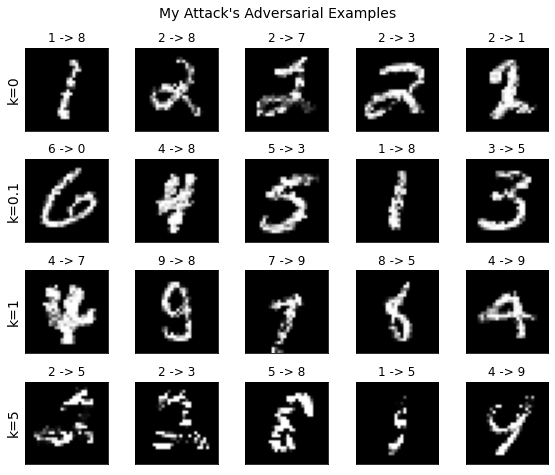

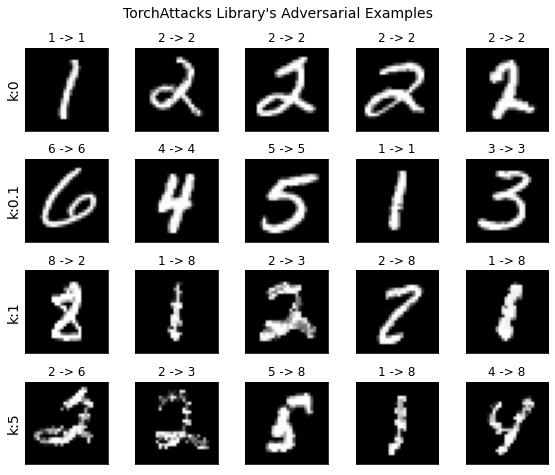

In [398]:
#kappas=[0,0.1,1,5]
# Plot several examples of adversarial samples at each kappa
cnt = 0
plt.figure(figsize=(8,6.67))
plt.suptitle("My Attack's Adversarial Examples", fontsize=14)
for i in range(len(kappas)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(kappas),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j==0:
            plt.ylabel(f'k={kappas[i]}',fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()


# Plot several examples of adversarial samples at each kappa
cnt = 0
plt.figure(figsize=(8,6.67))
plt.suptitle("TorchAttacks Library's Adversarial Examples",fontsize=14)
for i in range(len(kappas)):
    for j in range(len(examples2[i])):
        cnt += 1
        plt.subplot(len(kappas),len(examples2[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j==0:
            plt.ylabel(f'k:{kappas[i]}',fontsize=14)
        orig,adv,ex = examples2[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()



In [399]:
import pandas

df = pandas.DataFrame(data={"Kappas":kappas, "My Accuracy":accuracies, "Torchattacks Accuracy":accuracies2})
df

,Kappas,My Accuracy,Torchattacks Accuracy
0,0.0,0.0364,0.9809
1,0.1,0.0332,0.9809
2,1.0,0.0329,0.6579
3,5.0,0.0337,0.0343


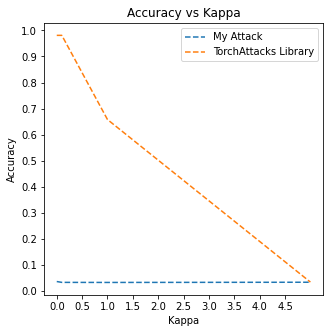

In [402]:
plt.figure(figsize=(5,5))
plt.plot(kappas, accuracies, "--", label="My Attack")
plt.plot(kappas, accuracies2, "--", label="TorchAttacks Library")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 5, step=0.5))
plt.title("Accuracy vs Kappa")
plt.xlabel("Kappa")
plt.ylabel("Accuracy")
plt.legend()
plt.show()